In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam

from celluloid import Camera

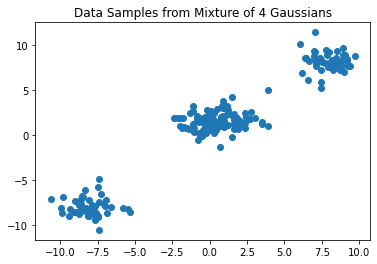

In [2]:
data = torch.cat((MultivariateNormal(-8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([1.5, 2]), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([-0.5, 1]), torch.eye(2)).sample([50])))

plt.scatter(data[:, 0], data[:, 1])
plt.title("Data Samples from Mixture of 4 Gaussians")
plt.show()
N = data.shape[0]

In [3]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

In [4]:
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))
        
    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(mix_weights(beta)))
        pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(2)), obs=data)

In [5]:
def guide(data):
    kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', lambda: Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", Categorical(phi))

In [80]:
T = 6
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

losses = []
kappas = []
taus = []
phis = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)
        kappas.append(pyro.param("kappa").detach())
        taus.append(pyro.param("tau").detach())
        phis.append(pyro.param("phi").detach())

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 1.0
n_iters = 1000
train(n_iters)

100%|██████████| 1000/1000 [00:57<00:00, 17.36it/s]


100%|██████████| 1000/1000 [00:10<00:00, 98.61it/s]


Creating animation...
Saving clusters.mp4...


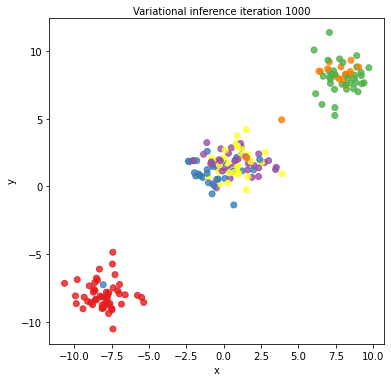

In [93]:
fig, ax = plt.subplots(figsize=(6, 6))
camera = Camera(fig)

n_points = data.shape[0]
n_clusters = T
n_iters_to_plot = 100

colors = plt.get_cmap("Set1")
cluster_colors = [colors(n) for n in range(n_clusters)]

for i in tqdm(range(n_iters)):
    centers = taus[i]
    weights = phis[i]
    
    data_colors = []
    for n in range(n_points):
        cluster_assignment = weights[n, :].argmax().item()
        data_colors.append(cluster_colors[cluster_assignment])
    
    ax.text(0.25, 1.01, f"Variational inference iteration {i+1}", transform=ax.transAxes)
    ax.scatter(data[:, 0], data[:, 1], color=data_colors, alpha=0.8)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    camera.snap()

print("Creating animation...")
anim = camera.animate(interval=50, blit=True)

print("Saving clusters.mp4...")
anim.save("clusters.mp4", dpi=200)

100%|██████████| 1000/1000 [00:02<00:00, 429.83it/s]


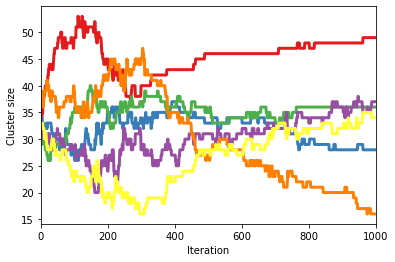

In [82]:
fig, ax = plt.subplots()

cluster_sizes = np.zeros((n_clusters, n_iters))

for i in tqdm(range(n_iters)):
    weights = phis[i]
    cluster_assignments = np.array([weights[n, :].argmax().item() for n in range(n_points)])
    
    for c in range(n_clusters):
        cluster_sizes[c, i] = np.count_nonzero(cluster_assignments == c)

for c in range(n_clusters):
    ax.plot(cluster_sizes[c, :], linewidth=3, color=cluster_colors[c])
    
ax.set_xlabel("Iteration")
ax.set_ylabel("Cluster size")
ax.set_xlim(0, n_iters)

fig.savefig("cluster_sizes.png", dpi=300)

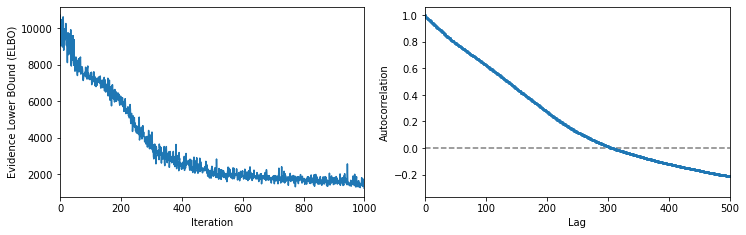

In [88]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12, 3.5))

ax1.plot(losses)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Evidence Lower BOund (ELBO)")
ax1.set_xlim(0, n_iters)

ax2.axhline(y=0, color="gray", linestyle="dashed")
ax2.acorr(np.asarray(losses), detrend=lambda x: x - x.mean(), maxlags=750, usevlines=False, marker=".", markersize=4)
ax2.set_xlabel("Lag")
ax2.set_ylabel("Autocorrelation")
ax2.set_xlim(0, 500)

plt.savefig("ELBO_and_autocorrelation.png", dpi=300)

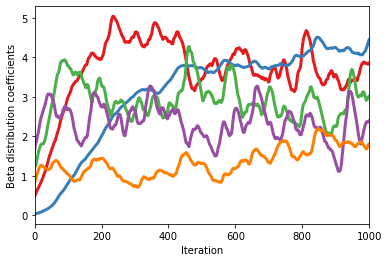

In [84]:
kappa_ts = {c: [kappas[n][c].item() for n in range(n_iters)] for c in range(T-1)}

fig = plt.Figure()
for c in range(T-1):
    plt.plot(kappa_ts[c], linewidth=3, color=cluster_colors[c])
plt.xlim(0, n_iters)
plt.xlabel("Iteration")
plt.ylabel("Beta distribution coefficients")

plt.savefig("Beta_distribution_coefficients.png", dpi=300)